# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 20:15 - loss: 0.6934

  23/1875 [..............................] - ETA: 4s - loss: 0.5635   

  49/1875 [..............................] - ETA: 3s - loss: 0.4764

  72/1875 [>.............................] - ETA: 3s - loss: 0.4357

  98/1875 [>.............................] - ETA: 3s - loss: 0.4064

 123/1875 [>.............................] - ETA: 3s - loss: 0.3865

 147/1875 [=>............................] - ETA: 3s - loss: 0.3717

 175/1875 [=>............................] - ETA: 3s - loss: 0.3578

 204/1875 [==>...........................] - ETA: 3s - loss: 0.3459

 234/1875 [==>...........................] - ETA: 3s - loss: 0.3354

 265/1875 [===>..........................] - ETA: 3s - loss: 0.3261

 295/1875 [===>..........................] - ETA: 3s - loss: 0.3183

 323/1875 [====>.........................] - ETA: 2s - loss: 0.3117

 350/1875 [====>.........................] - ETA: 2s - loss: 0.3059

 373/1875 [====>.........................] - ETA: 2s - loss: 0.3014

 398/1875 [=====>........................] - ETA: 2s - loss: 0.2969

 418/1875 [=====>........................] - ETA: 2s - loss: 0.2934

 444/1875 [======>.......................] - ETA: 2s - loss: 0.2893

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2854

 500/1875 [=======>......................] - ETA: 2s - loss: 0.2811

 529/1875 [=======>......................] - ETA: 2s - loss: 0.2773

 558/1875 [=======>......................] - ETA: 2s - loss: 0.2738

 586/1875 [========>.....................] - ETA: 2s - loss: 0.2705

 609/1875 [========>.....................] - ETA: 2s - loss: 0.2680

 633/1875 [=========>....................] - ETA: 2s - loss: 0.2655

 655/1875 [=========>....................] - ETA: 2s - loss: 0.2633

 676/1875 [=========>....................] - ETA: 2s - loss: 0.2612

 700/1875 [==========>...................] - ETA: 2s - loss: 0.2590

 725/1875 [==========>...................] - ETA: 2s - loss: 0.2568

 751/1875 [===========>..................] - ETA: 2s - loss: 0.2545

 779/1875 [===========>..................] - ETA: 2s - loss: 0.2522

 805/1875 [===========>..................] - ETA: 2s - loss: 0.2502

 831/1875 [============>.................] - ETA: 2s - loss: 0.2482

 858/1875 [============>.................] - ETA: 1s - loss: 0.2462

 885/1875 [=============>................] - ETA: 1s - loss: 0.2443

 911/1875 [=============>................] - ETA: 1s - loss: 0.2426

 939/1875 [==============>...............] - ETA: 1s - loss: 0.2407

 968/1875 [==============>...............] - ETA: 1s - loss: 0.2389

 995/1875 [==============>...............] - ETA: 1s - loss: 0.2372

1024/1875 [===============>..............] - ETA: 1s - loss: 0.2355

1053/1875 [===============>..............] - ETA: 1s - loss: 0.2339

1080/1875 [================>.............] - ETA: 1s - loss: 0.2324

1108/1875 [================>.............] - ETA: 1s - loss: 0.2309

1135/1875 [=================>............] - ETA: 1s - loss: 0.2295

1161/1875 [=================>............] - ETA: 1s - loss: 0.2282

1187/1875 [=================>............] - ETA: 1s - loss: 0.2269

1213/1875 [==================>...........] - ETA: 1s - loss: 0.2256

1237/1875 [==================>...........] - ETA: 1s - loss: 0.2245

1261/1875 [===================>..........] - ETA: 1s - loss: 0.2234

1289/1875 [===================>..........] - ETA: 1s - loss: 0.2222

1318/1875 [====================>.........] - ETA: 1s - loss: 0.2209

1345/1875 [====================>.........] - ETA: 1s - loss: 0.2198

1371/1875 [====================>.........] - ETA: 0s - loss: 0.2187

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2176

1426/1875 [=====================>........] - ETA: 0s - loss: 0.2165

1451/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1476/1875 [======================>.......] - ETA: 0s - loss: 0.2146

1503/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1532/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1561/1875 [=======================>......] - ETA: 0s - loss: 0.2115

1590/1875 [========================>.....] - ETA: 0s - loss: 0.2105

1617/1875 [========================>.....] - ETA: 0s - loss: 0.2096

1646/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1672/1875 [=========================>....] - ETA: 0s - loss: 0.2078

1699/1875 [==========================>...] - ETA: 0s - loss: 0.2069

1725/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1754/1875 [===========================>..] - ETA: 0s - loss: 0.2053

1781/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2036

1838/1875 [============================>.] - ETA: 0s - loss: 0.2028

1866/1875 [============================>.] - ETA: 0s - loss: 0.2020

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2017


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1102

  28/1875 [..............................] - ETA: 3s - loss: 0.1087

  55/1875 [..............................] - ETA: 3s - loss: 0.1088

  83/1875 [>.............................] - ETA: 3s - loss: 0.1087

 110/1875 [>.............................] - ETA: 3s - loss: 0.1087

 135/1875 [=>............................] - ETA: 3s - loss: 0.1086

 164/1875 [=>............................] - ETA: 3s - loss: 0.1086

 193/1875 [==>...........................] - ETA: 3s - loss: 0.1086

 222/1875 [==>...........................] - ETA: 3s - loss: 0.1085

 251/1875 [===>..........................] - ETA: 2s - loss: 0.1085

 278/1875 [===>..........................] - ETA: 2s - loss: 0.1084

 304/1875 [===>..........................] - ETA: 2s - loss: 0.1084

 331/1875 [====>.........................] - ETA: 2s - loss: 0.1084

 358/1875 [====>.........................] - ETA: 2s - loss: 0.1083

 384/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 411/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 437/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 465/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 493/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 520/1875 [=======>......................] - ETA: 2s - loss: 0.1080

 548/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 576/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 603/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 633/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 662/1875 [=========>....................] - ETA: 2s - loss: 0.1077

 690/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 720/1875 [==========>...................] - ETA: 2s - loss: 0.1076

 747/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 773/1875 [===========>..................] - ETA: 2s - loss: 0.1075

 800/1875 [===========>..................] - ETA: 1s - loss: 0.1074

 826/1875 [============>.................] - ETA: 1s - loss: 0.1074

 855/1875 [============>.................] - ETA: 1s - loss: 0.1073

 875/1875 [=============>................] - ETA: 1s - loss: 0.1073

 903/1875 [=============>................] - ETA: 1s - loss: 0.1072

 930/1875 [=============>................] - ETA: 1s - loss: 0.1072

 960/1875 [==============>...............] - ETA: 1s - loss: 0.1071

 987/1875 [==============>...............] - ETA: 1s - loss: 0.1070

1011/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1029/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1050/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1073/1875 [================>.............] - ETA: 1s - loss: 0.1069

1097/1875 [================>.............] - ETA: 1s - loss: 0.1068

1119/1875 [================>.............] - ETA: 1s - loss: 0.1068

1148/1875 [=================>............] - ETA: 1s - loss: 0.1067

1176/1875 [=================>............] - ETA: 1s - loss: 0.1067

1199/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1225/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1250/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1277/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1303/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1329/1875 [====================>.........] - ETA: 1s - loss: 0.1064

1357/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1378/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1402/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1421/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1447/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1476/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1503/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1523/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1547/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1569/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1592/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1618/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1640/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1662/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1687/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1711/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1736/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1763/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1785/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1811/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1841/1875 [============================>.] - ETA: 0s - loss: 0.1055

1869/1875 [============================>.] - ETA: 0s - loss: 0.1055

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1055


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0917

  33/1875 [..............................] - ETA: 2s - loss: 0.0986

  62/1875 [..............................] - ETA: 3s - loss: 0.0986

  90/1875 [>.............................] - ETA: 3s - loss: 0.0985

 119/1875 [>.............................] - ETA: 3s - loss: 0.0983

 145/1875 [=>............................] - ETA: 3s - loss: 0.0982

 171/1875 [=>............................] - ETA: 3s - loss: 0.0982

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0982

 220/1875 [==>...........................] - ETA: 3s - loss: 0.0981

 242/1875 [==>...........................] - ETA: 3s - loss: 0.0981

 265/1875 [===>..........................] - ETA: 3s - loss: 0.0981

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0981

 315/1875 [====>.........................] - ETA: 3s - loss: 0.0981

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 375/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 491/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0980

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0980

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 696/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 725/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 754/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 780/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 803/1875 [===========>..................] - ETA: 1s - loss: 0.0979

 827/1875 [============>.................] - ETA: 1s - loss: 0.0979

 857/1875 [============>.................] - ETA: 1s - loss: 0.0978

 880/1875 [=============>................] - ETA: 1s - loss: 0.0978

 905/1875 [=============>................] - ETA: 1s - loss: 0.0978

 934/1875 [=============>................] - ETA: 1s - loss: 0.0978

 962/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0978

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1069/1875 [================>.............] - ETA: 1s - loss: 0.0978

1097/1875 [================>.............] - ETA: 1s - loss: 0.0978

1123/1875 [================>.............] - ETA: 1s - loss: 0.0978

1149/1875 [=================>............] - ETA: 1s - loss: 0.0978

1178/1875 [=================>............] - ETA: 1s - loss: 0.0977

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0977

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1825/1875 [============================>.] - ETA: 0s - loss: 0.0976

1853/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0976


Epoch 4/5


   1/1875 [..............................] - ETA: 3s - loss: 0.0988

  25/1875 [..............................] - ETA: 3s - loss: 0.0983

  52/1875 [..............................] - ETA: 3s - loss: 0.0980

  75/1875 [>.............................] - ETA: 3s - loss: 0.0978

 103/1875 [>.............................] - ETA: 3s - loss: 0.0975

 128/1875 [=>............................] - ETA: 3s - loss: 0.0974

 151/1875 [=>............................] - ETA: 3s - loss: 0.0972

 178/1875 [=>............................] - ETA: 3s - loss: 0.0971

 206/1875 [==>...........................] - ETA: 3s - loss: 0.0970

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0969

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0968

 294/1875 [===>..........................] - ETA: 3s - loss: 0.0967

 321/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 374/1875 [====>.........................] - ETA: 2s - loss: 0.0965

 399/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 555/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 640/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 661/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 703/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 728/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 752/1875 [===========>..................] - ETA: 2s - loss: 0.0961

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0961

 805/1875 [===========>..................] - ETA: 2s - loss: 0.0961

 830/1875 [============>.................] - ETA: 2s - loss: 0.0961

 854/1875 [============>.................] - ETA: 2s - loss: 0.0961

 877/1875 [=============>................] - ETA: 2s - loss: 0.0961

 898/1875 [=============>................] - ETA: 2s - loss: 0.0960

 922/1875 [=============>................] - ETA: 1s - loss: 0.0960

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1070/1875 [================>.............] - ETA: 1s - loss: 0.0960

1098/1875 [================>.............] - ETA: 1s - loss: 0.0960

1125/1875 [=================>............] - ETA: 1s - loss: 0.0960

1153/1875 [=================>............] - ETA: 1s - loss: 0.0960

1174/1875 [=================>............] - ETA: 1s - loss: 0.0960

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1832/1875 [============================>.] - ETA: 0s - loss: 0.0959

1855/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0997

  26/1875 [..............................] - ETA: 3s - loss: 0.0969

  50/1875 [..............................] - ETA: 3s - loss: 0.0963

  72/1875 [>.............................] - ETA: 3s - loss: 0.0959

 102/1875 [>.............................] - ETA: 3s - loss: 0.0957

 129/1875 [=>............................] - ETA: 3s - loss: 0.0956

 158/1875 [=>............................] - ETA: 3s - loss: 0.0955

 187/1875 [=>............................] - ETA: 3s - loss: 0.0955

 216/1875 [==>...........................] - ETA: 3s - loss: 0.0955

 246/1875 [==>...........................] - ETA: 3s - loss: 0.0955

 272/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 299/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 354/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 380/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 462/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 491/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 540/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 567/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 591/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 665/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 692/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 774/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 821/1875 [============>.................] - ETA: 2s - loss: 0.0955

 848/1875 [============>.................] - ETA: 1s - loss: 0.0955

 874/1875 [============>.................] - ETA: 1s - loss: 0.0955

 894/1875 [=============>................] - ETA: 1s - loss: 0.0955

 915/1875 [=============>................] - ETA: 1s - loss: 0.0955

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 993/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1070/1875 [================>.............] - ETA: 1s - loss: 0.0954

1096/1875 [================>.............] - ETA: 1s - loss: 0.0954

1123/1875 [================>.............] - ETA: 1s - loss: 0.0954

1151/1875 [=================>............] - ETA: 1s - loss: 0.0954

1178/1875 [=================>............] - ETA: 1s - loss: 0.0954

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1375/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1815/1875 [============================>.] - ETA: 0s - loss: 0.0954

1843/1875 [============================>.] - ETA: 0s - loss: 0.0954

1871/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

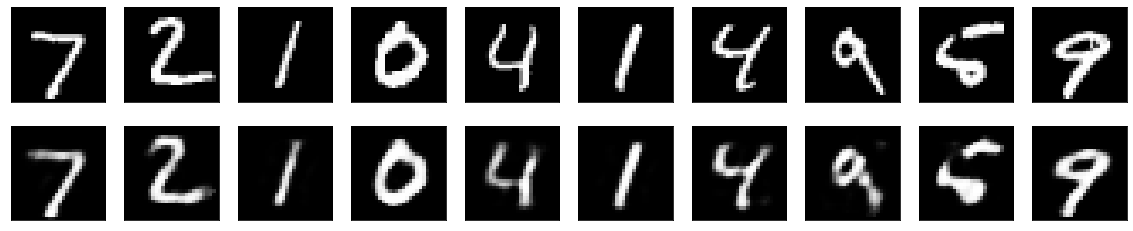

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
